In [1]:
import pandas as pd
from sklearn import tree
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_tree = pd.read_csv('3_task_data.csv')

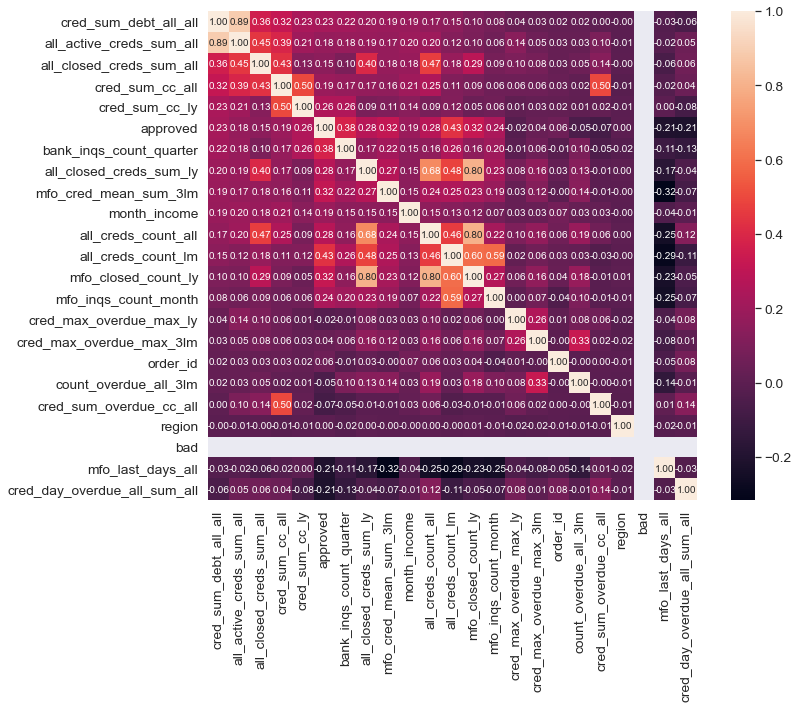

In [3]:
#correlation matrix
corrmat = df_tree.corr()
k = 23 #number of variables for heatmap
cols = corrmat.nlargest(k, 'cred_sum_debt_all_all')['cred_sum_debt_all_all'].index
cm = np.corrcoef(df_tree[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- cred_sum_debt_all_all(Сумма задолженности по всем кредитам) 
  коэф.корр 0.89 с all_active_creds_sum_all - денежная сумма всех активных кредитов
- mfo_closed_count_ly - Количество закрытых МФО кредитов, взятых за последний год 
  (чем больше закрытых кредитов тем больше сумма закрытых)
  коэф корр 0.8 с all_closed_creds_sum_ly - Сумма закрытых кредитов за последний год

  -и all_creds_count_all - Общее количество кредитов
  (чем больше у тебя кредитов тем больше ты их и закрываешь)

In [17]:
X_train, y_train = df_tree.drop(['order_id','bad','approved'],axis=1) ,df_tree['approved']

In [18]:
#Обучим дерево решений, чтобы понять какие признаки больше влияют на одобрение кредита (approved)
# Установим параметр max_depth ,чтобы лучше определить првила разделения (важные признаки),а не подогнать под этот набор данных
clf = tree.DecisionTreeClassifier(max_depth = 10, random_state = 24)
clf = clf.fit(X_train, y_train)

In [19]:
importances = pd.DataFrame({'feature':list(X_train), 'importance': np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending =False)
importances

,feature,importance
8,cred_sum_debt_all_all,0.383
13,cred_day_overdue_all_sum_all,0.217
12,all_creds_count_all,0.110
9,all_closed_creds_sum_ly,0.049
16,cred_sum_overdue_cc_all,0.037
7,cred_sum_cc_ly,0.032
11,delay_more_sum_all,0.028
2,all_closed_creds_sum_all,0.028
0,cred_sum_cc_all,0.024
3,bank_inqs_count_quarter,0.016


#### DecisionTree показало какие признаки были наиболее значимы при  одобрении и отказу
1. Сумма задолженности по всем кредитам -38,3%
2. Суммарное количество дней просрочки текущих активных кредитов 21,7%
3. Общее количество кредитов -11%
4. Сумма закрытых кредитов за последний год - 4,8%
5. Сумма просрочек по кредитным картам - 3,7%
6. Сумма лимитов кредитных карт, оформленных за последний год 3,2%

* Стоит отметить, что характеризующие клиента work_code и month_income значимо не влияют на одобрение кредита 

In [7]:
d = {0 : 'отказано', 1 : 'одобрено'}
df_tree['approved'] = df_tree['approved'].map(d)

In [8]:
# df где клиентом одобренно
df_approve = df_tree[df_tree['approved'] == 'одобрено']

In [16]:
#Обучим дерево решений, чтобы понять какие признаки больше влияют на просрок/возврат кредита (bad) среди тех кому было одобренно
X_train, y_train = df_approve.drop(['order_id','bad','approved'],axis=1) ,df_approve['bad']
clf_2 = tree.DecisionTreeClassifier(max_depth = 10, random_state = 24)
clf_2 = clf_2.fit(X_train, y_train)
importances = pd.DataFrame({'feature':list(X_train), 'importance': np.round(clf_2.feature_importances_,3)})
importances = importances.sort_values('importance',ascending =False)
importances

,feature,importance
9,all_closed_creds_sum_ly,0.077
2,all_closed_creds_sum_all,0.075
10,mfo_cred_mean_sum_3lm,0.071
21,region,0.066
8,cred_sum_debt_all_all,0.065
3,bank_inqs_count_quarter,0.061
1,mfo_inqs_count_month,0.061
12,all_creds_count_all,0.059
0,cred_sum_cc_all,0.059
6,mfo_last_days_all,0.058


#### Среди тех кому был одобенно возвращают не все. Посмотрим что влияет на возврат/просрок кредита
1.  Сумма закрытых кредитов за последний год - 7,7% (корреляция с 2 пунктом . попробовать удалить )
2. сумма закрытых кредитов -7,6 %
3.   Средняя сумма МФО кредитов, выданных за последние 3 7,1%
4.  регион - 6,6 %
5. Сумма задолженности по всем кредитам - 6,5%
6. количество запросов на кредиты в другие в МФО - 6,1% 
7.  количество запросов на кредиты в банки - 6%
8. Общее количество кредитов - 5,9% 
9. сумма кредитов по кредитным картам - 5,9%
10. Количество дней с последнего займа в МФО - 5,8% 
11. максимальная просрочка за год - 5,5% 

In [20]:
#Обучим удалив столбец  Сумма закрытых кредитов за последний год оставив сумма закрытых кредитов
X_train, y_train = df_approve.drop(['order_id','bad','approved','all_closed_creds_sum_ly'],axis=1) ,df_approve['bad']
clf_2 = tree.DecisionTreeClassifier(max_depth = 10, random_state = 24)
clf_2 = clf_2.fit(X_train, y_train)
importances = pd.DataFrame({'feature':list(X_train), 'importance': np.round(clf_2.feature_importances_,3)})
importances = importances.sort_values('importance',ascending =False)
importances

,feature,importance
2,all_closed_creds_sum_all,0.088
9,mfo_cred_mean_sum_3lm,0.086
6,mfo_last_days_all,0.079
20,region,0.075
8,cred_sum_debt_all_all,0.070
1,mfo_inqs_count_month,0.064
11,all_creds_count_all,0.063
0,cred_sum_cc_all,0.054
4,cred_max_overdue_max_ly,0.054
3,bank_inqs_count_quarter,0.050


Посмотрим что влияет на возврат/просрок кредита после удаления столбца
1.  Сумма закрытых кредитов  - 8,8% 
2. Средняя сумма МФО кредитов, выданных за последние 3 8,6%
3.   Количество дней с последнего займа в МФО - 7,9%
4.  регион - 7,5 %
5. Сумма задолженности по всем кредитам - 7%
6. количество запросов на кредиты в другие в МФО - 6,4% 
7. Общее количество кредитов - 6,2%
8. сумма кредитов по кредитным картам - 5,5%  
9.  максимальная просрочка за год - 5,5%
10. количество запросов на кредиты в банки - 6%